# Import all the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1OlPNGs1RA5a6ibRiIhhlVJXbo_ikhKuQ'})  
downloaded.GetContentFile('Twitter_Data.csv') 

# Read the data into a DataFrame

In [4]:
df = pd.read_csv('Twitter_Data.csv')

In [5]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
df.shape

(162980, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


# Exploratory data analysis

In [8]:
# Check count of  Null values
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [9]:
# Get all Category Null values
df[df['category'].isna()]

,clean_text,category
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
159442,chidambaram gives praises modinomics,NaN
160559,the reason why modi contested from seats 2014 ...,NaN


In [10]:
# Get all Clean Text Null values

df[df['clean_text'].isna()]

,clean_text,category
148,NaN,0.0
158694,NaN,-1.0
159443,NaN,0.0
160560,NaN,1.0


In [11]:
# Drop all Null values
df.dropna(inplace = True)
df.isna().sum()

clean_text    0
category      0
dtype: int64

In [12]:
df.shape

(162969, 2)

In [13]:
# Check the values of target variable
df['category'].value_counts()

 1.0    72249
 0.0    55211
-1.0    35509
Name: category, dtype: int64

In [14]:
# Convert Float to Int
df['category'] = df['category'].astype(int)

In [15]:
# Encode target variables
df['category'].replace({-1:1, 0:2, 1:3}, inplace = True)
df['category'].value_counts()

3    72249
2    55211
1    35509
Name: category, dtype: int64

# Data Visualization

Text(0.5, 1.0, 'Dataset target distribuition')

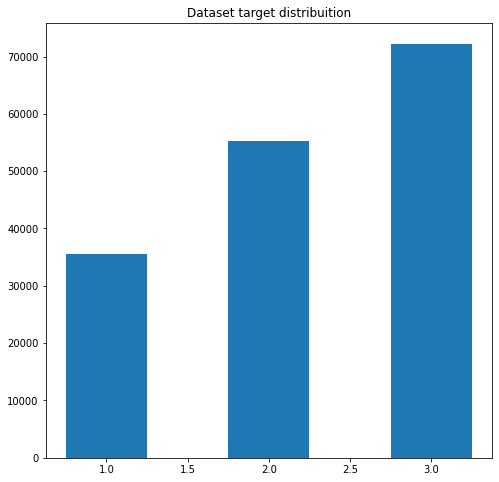

In [16]:
target_cnt = Counter(df['category'])
plt.figure(figsize=(8,8))
plt.bar(target_cnt.keys(), target_cnt.values(), width= 0.5)
plt.title("Dataset target distribuition")

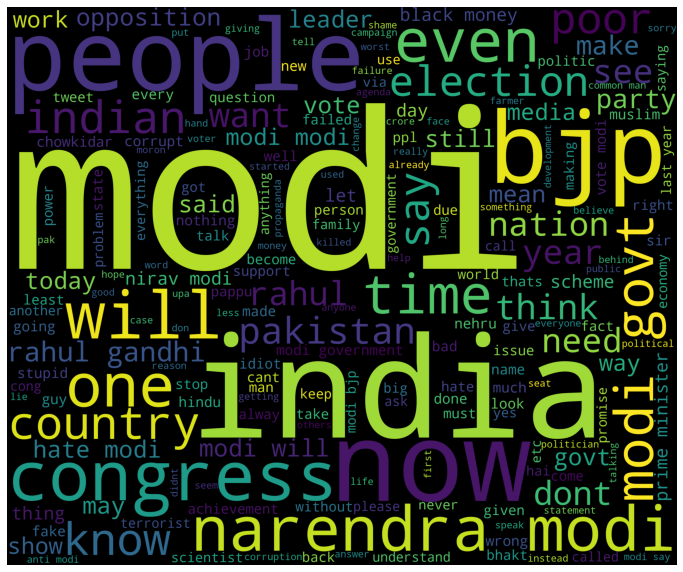

In [17]:
# Word Cloud for Negative Sentiments

new_df=df[df['category']==1]
words = ' '.join(new_df['clean_text'])
cleaned_word = " ".join([word for word in words.split()])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

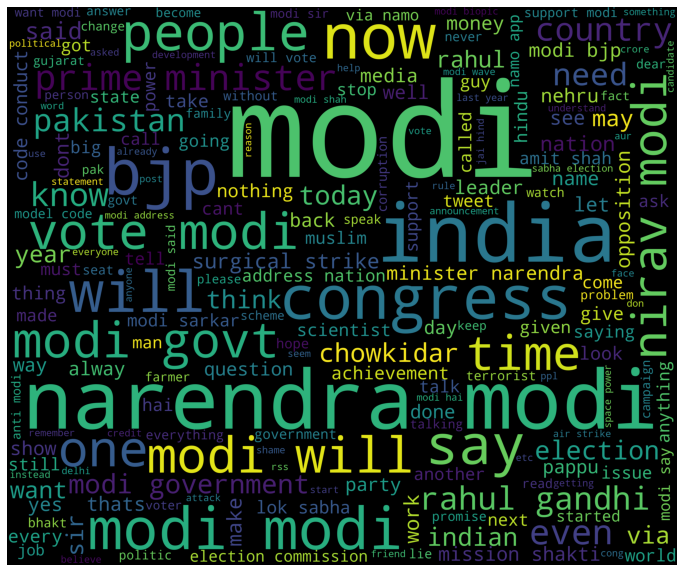

In [18]:
# Word Cloud for Neutral Sentiments

new_df=df[df['category']==2]
words = ' '.join(new_df['clean_text'])
cleaned_word = " ".join([word for word in words.split()])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

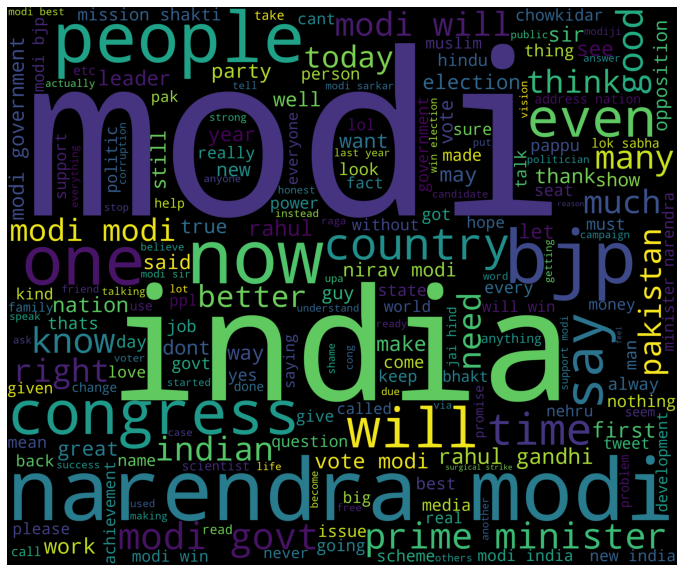

In [19]:
# Word Cloud for Positive Sentiments

new_df=df[df['category']==3]
words = ' '.join(new_df['clean_text'])
cleaned_word = " ".join([word for word in words.split()])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Data Preprocessing

In [20]:
df['clean_text']

0         when modi promised “minimum government maximum...
1         talk all the nonsense and continue all the dra...
2         what did just say vote for modi  welcome bjp t...
3         asking his supporters prefix chowkidar their n...
4         answer who among these the most powerful world...
                                ...                        
162975    why these 456 crores paid neerav modi not reco...
162976    dear rss terrorist payal gawar what about modi...
162977    did you cover her interaction forum where she ...
162978    there big project came into india modi dream p...
162979    have you ever listen about like gurukul where ...
Name: clean_text, Length: 162969, dtype: object

In [21]:
# Preprocess the tweets

rem = r'@[A-Za-z0-9_]+'          # remove @ mentions fron tweets
remurl = r'https?://[^ ]+'        # remove URL's from tweets
remwww = r'www.[^ ]+'
remdig = r'\d+'                   # remove digits from tweets
rempun = r'[^\w\s]'               # remove all punctuations
remdspc = r'/\s\s+/g'                  # replace double space to single space
remsng = r'\b[a-zA-Z]\b'          # remove all single characters
rem_all = r'|'.join((rem, remurl, remwww, remdig, rempun, remdspc, remsng))

# Clean the data
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(rem_all, '', x))

In [22]:
# Convert into lower case
df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())

df['clean_text']

0         when modi promised minimum government maximum ...
1         talk all the nonsense and continue all the dra...
2         what did just say vote for modi  welcome bjp t...
3         asking his supporters prefix chowkidar their n...
4         answer who among these the most powerful world...
                                ...                        
162975    why these  crores paid neerav modi not recover...
162976    dear rss terrorist payal gawar what about modi...
162977    did you cover her interaction forum where she ...
162978    there big project came into india modi dream p...
162979    have you ever listen about like gurukul where ...
Name: clean_text, Length: 162969, dtype: object

In [23]:
# Remove stop words

STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove("not")
df['text'] = df['clean_text'].apply(lambda text: text.split())
df['text'] = df['text'].apply(lambda text: [word for word in text if not word in STOPWORDS])

In [24]:
# Lemmatization (using Lemmatization over stemming as Lemmatization will give better results and we are not dealing with huge data)

lemmatizer = WordNetLemmatizer()

df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
df['text']=[" ".join(review) for review in df['text'].values]

In [25]:
df

,clean_text,category,text
0,when modi promised minimum government maximum ...,1,modi promised minimum government maximum gover...
1,talk all the nonsense and continue all the dra...,2,talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,3,say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,3,asking supporter prefix chowkidar name modi gr...
4,answer who among these the most powerful world...,3,answer among powerful world leader today trump...
...,...,...,...
162975,why these crores paid neerav modi not recover...,1,crore paid neerav modi not recovered congress ...
162976,dear rss terrorist payal gawar what about modi...,1,dear r terrorist payal gawar modi killing plus...
162977,did you cover her interaction forum where she ...,2,cover interaction forum left
162978,there big project came into india modi dream p...,2,big project came india modi dream project not ...


# Split the data into train and test

In [26]:
X = df['text']
y = df['category']

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1)

In [27]:
# Using Count Vectorizer

vectorizer = CountVectorizer(analyzer='word')

X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

In [28]:
# Using TFIDF Vectorizer

tf_idf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))

X_train_tf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf = tf_idf_vectorizer.transform(X_test)

# Using Multinomial navie bayers classifier with Count Vectorizer

In [29]:
#Create a Multinomial navie bayers classifier

model = MultinomialNB()
model.fit(X_train_cv,y_train)
y_pred_cv = model.predict(X_test_cv)

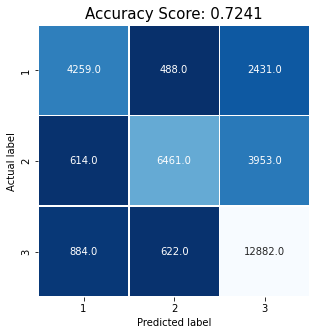

In [30]:
# plot confusion matrix
# Since this is multi class classification, we will get multi class confusion matrix

TARGET_COLUMN='category'

cm_MNB=metrics.confusion_matrix(y_test,y_pred_cv)

target_labels=sorted(df[TARGET_COLUMN].unique())
df_cm_MNB = pd.DataFrame(cm_MNB, index=target_labels, columns=target_labels)


plt.figure(figsize=(16,5))
sns.heatmap(df_cm_MNB, annot=True, fmt=".1f", linewidths=.8, square = True, cbar=False, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.4f}'.format(metrics.accuracy_score(y_test,y_pred_cv))
plt.title(all_sample_title, size = 15);

In [31]:
# Print the accuracy score
print(f'Count Vectorizer Accuracy score = {accuracy_score( y_test, y_pred_cv)}')

Count Vectorizer Accuracy score = 0.7241210038657422


# Using Multinomial navie bayers classifier with TFIDF vectorizer

In [32]:
#Create a Multinomial navie bayers classifier

model = MultinomialNB()
model.fit(X_train_tf,y_train)
y_pred_tf = model.predict(X_test_tf)

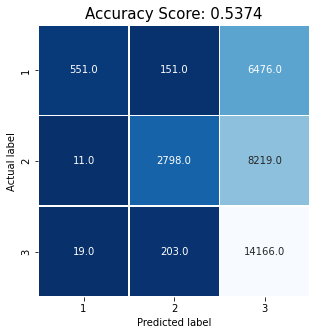

In [33]:
# plot confusion matrix
# Since this is multi class classification, we will get multi class confusion matrix

TARGET_COLUMN='category'

cm_MNB=metrics.confusion_matrix(y_test,y_pred_tf)

target_labels=sorted(df[TARGET_COLUMN].unique())
df_cm_MNB = pd.DataFrame(cm_MNB, index=target_labels, columns=target_labels)


plt.figure(figsize=(16,5))
sns.heatmap(df_cm_MNB, annot=True, fmt=".1f", linewidths=.8, square = True, cbar=False, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.4f}'.format(metrics.accuracy_score(y_test,y_pred_tf))
plt.title(all_sample_title, size = 15);

In [34]:
# Print the accuracy score
print(f'TFIDF Vectorizer Accuracy score = {accuracy_score( y_test, y_pred_tf)}')

TFIDF Vectorizer Accuracy score = 0.5373688408909615


# <font color='red'> Count Vectorizer is performing better than TFIDF in Multinomial NB classifier </font>